In [3]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
import pickle
# from tensorflow.contrib import lite
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.utils import np_utils
from keras.models import load_model
from keras import backend as K
import random
from random import randrange

# %matplotlib notebook

In [54]:
# Formata os arquivos em dicionário na forma:
# {'a': [0...[0...[0...30]...100]...10]}
# 30 dados (gx, gy, gz, ax, ay, az para 5 dedos)
# com 100 amostras para cada sinal
# e realizado 10 vezes

directory = 'Dados_alfabeto'
letras = os.listdir(directory) 
num_letras = len(letras)

dataset = pd.DataFrame()

files = {}
for letra in letras:
    files[letra] = os.listdir(directory+'/'+letra)

stats = []
all_dataframe = {}
    
# formated_dict = {}
for letra, value_list in files.items():
#     formated_dict[letra] = []
    for f in value_list:
        with open(directory+"/"+letra+"/"+f) as file:
            lines = [line.strip() for line in file]
            lines = ast.literal_eval(lines[0])
            test = pd.DataFrame(lines)
            d = {'media':test.mean(), 'desvio_padrao': test.std(), 'max': test.max(), 'min': test.min()}

            stats.append(pd.DataFrame(d))
            test['label'] = letra
            dataset = dataset.append(test, ignore_index = True)
            
            if letra not in all_dataframe:
                all_dataframe[letra] = []
            all_dataframe[letra].append(test)
#             formated_dict[letra].append(lines)

if not os.path.exists('./estatisticas'):
    os.mkdir('./estatisticas')

estatisticas = {}
# letras_list = ['a','b','c','d','e','f','g','i','l','m','n','o','p','q','r','s','t','u','v','w']
i = 0;
for letr in letras:
    estatisticas[letr] = stats[i:i+10]
    i+=10
    
for key,list_values in estatisticas.items():
    for i,v in enumerate(list_values):
        v.to_excel('./estatisticas/' + key+'_'+str(i)+'.xlsx')

In [55]:
mini_dataset_train = []
mini_dataset_test = []
for letr in letras:
    for i in range(10):
#         aleat = randrange(100)+100*i
        aleat = [ num + 100*i for num in random.sample(range(100), 2) ]
        mini_dataset_train.append(dataset[dataset.label==letr].iloc[aleat[0]])
        mini_dataset_test.append(dataset[dataset.label==letr].iloc[aleat[1]])
        
mini_dataset_train = pd.DataFrame(mini_dataset_train).reset_index()
mini_dataset_train = mini_dataset_train.drop('index', 1)

mini_dataset_test = pd.DataFrame(mini_dataset_test).reset_index()
mini_dataset_test = mini_dataset_test.drop('index', 1)

mini_dataset_train.to_csv('mini_dataset_train.csv')
mini_dataset_test.to_csv('mini_dataset_test.csv')

In [60]:
dataset = mini_dataset_train

X = dataset.iloc[:,0:30] 
y = dataset.iloc[:,30] 

y = LabelEncoder().fit_transform(y)

X = X/16384
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Tranform training labels to one-hot encoding
y_train = np_utils.to_categorical(y_train, num_letras)

# Tranform test labels to one-hot encoding
y_val = np_utils.to_categorical(y_val, num_letras)

In [67]:
X_train = X_train.reset_index().iloc[:,1:31]
X_val = X_val.reset_index().iloc[:,1:31]

In [76]:
mini_dataset_test.to_csv('mini_dataset_test.csv')

In [73]:
np.savetxt("labels_train.csv", y_train, delimiter=",")

In [41]:
for neurons in range(1,51):

    model = Sequential()

    classes = num_letras
    # hidden_layers = 0
    # neurons = [25] * hidden_layers
    # neurons = 1
    epochs = 10000

    # Camada de entrada
    model.add(Dense(units=neurons, activation='sigmoid', input_dim=30))

    # model.add(Dropout(0.2))
    # Camadas escondidas
    # for i in range(hidden_layers):
    #     model.add(Dense(units=neurons[i], activation='sigmoid'))

    # Camada de saída\
    model.add(Dense(units=classes, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size = 20, validation_data=(X_val, y_val), verbose=0)
    loss, accuracy = model.evaluate(X_val, y_val)

    with open('variacao_neuronios/' + str(neurons) + '_neurons.pickle', 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # model.save('modelo_alfabeto_treinado.h5')

ValueError: Error when checking input: expected dense_5_input to have shape (30,) but got array with shape (29,)

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


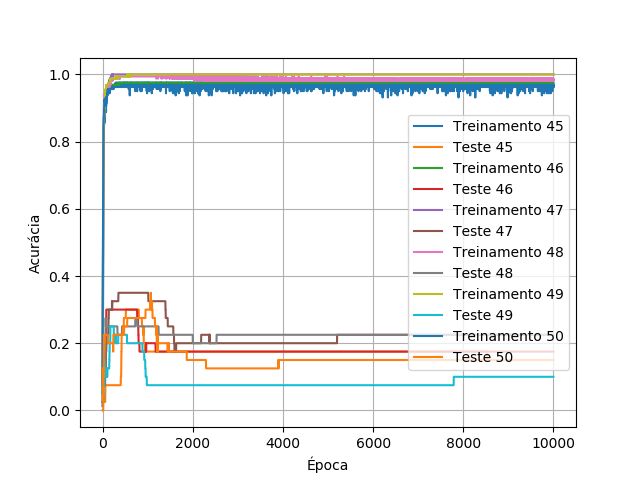

In [4]:
legend = []
for i in range(45,51):
    with open('variacao_neuronios/'+str(i)+'_neurons.pickle', 'rb') as handle:
        history = pickle.load(handle)
        
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    legend = legend + ['Treinamento ' + str(i), 'Teste '+ str(i)]
    
plt.legend(legend, loc='best')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.grid()
plt.rcParams['figure.figsize'] = [100, 50]
plt.show()

In [5]:
plt.clf()

In [ ]:
legend = []
for i in range(12,15):
    with open('variacao_neuronios/'+str(i)+'_neurons.pickle', 'rb') as handle:
        history = pickle.load(handle)
        
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    legend = legend + ['Treinamento ' + str(i), 'Teste '+ str(i)]
    
plt.legend(legend, loc='best')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.grid()
plt.rcParams['figure.figsize'] = [100, 50]
plt.show()

In [ ]:
def gerar_dic_conv_hist():
    nome_dados = ['ax0', 'ay0', 'az0', 'gx0', 'gy0', 'gz0',
                 'ax1', 'ay1', 'az1', 'gx1', 'gy1', 'gz1',
                 'ax2', 'ay2', 'az2', 'gx2', 'gy2', 'gz2',
                 'ax3', 'ay3', 'az3', 'gx3', 'gy3', 'gz3',
                 'ax4', 'ay4', 'az4', 'gx4', 'gy4', 'gz4']

    dic_conv_hist = {}
    for i,nom in enumerate(nome_dados):
        dic_conv_hist[i] = nom
    return dic_conv_hist
        

def save_histogramas(all_dataframe, letras):
    if not os.path.exists('./histogramas'):
        os.mkdir('./histogramas')

    for letra in letras:
        if not os.path.exists('./histogramas/'+letra):
            os.mkdir('./histogramas/'+letra)
        for ex in range(10):
            if not os.path.exists('./histogramas/'+letra+"/"+str(ex)):
                os.mkdir('./histogramas/'+letra+"/"+str(ex))
        
    dic_conv_hist = gerar_dic_conv_hist()

    for letra in letras:
        for ex in range(10):
            direc = './histogramas/'+letra+"/"+ str(ex) + "/"
            for dado in range(30):
                figure = all_dataframe[letra][ex].iloc[:,dado].hist(bins=100).get_figure()
                plt.tight_layout()
                figure.savefig(direc + letra + "_" + dic_conv_hist[dado] + ".png")
                plt.clf()
                

def get_estatisticas_por_letra(estatisticas, letras):

    est_letra = {}
    for key,list_values in estatisticas.items():
        est_letra[key] = pd.DataFrame()
        for i,v in enumerate(list_values):
            est_letra[key] = est_letra[key].append(pd.DataFrame(v))
        est_letra[key] = est_letra[key].reset_index()

    est_tmp = {}
    dic_conv_hist = gerar_dic_conv_hist()

    for letra in letras:
        est_tmp[letra] = []
        for i in range(30):
            tmp_pd = est_letra[letra][i::30]
            dic_tmp = {'desvio_padrao': tmp_pd['desvio_padrao'].std(ddof=0), 
                       'max': tmp_pd['max'].max(), 
                       'min': tmp_pd['min'].min(),
                       'label': dic_conv_hist[i]
                      }
            est_tmp[letra].append(pd.DataFrame(dic_tmp, index=[i]))
    
    if not os.path.exists('./estatisticas_gerais'):
        os.mkdir('./estatisticas_gerais')
    
    estatisticas_geral = {}
    for letra in letras:
        estatisticas_geral[letra] = pd.concat(est_tmp[letra])
        estatisticas_geral[letra].to_excel('./estatisticas_gerais/'+letra+'.xlsx')
        
    return estatisticas_geral


# dic_conv = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'i':7,
#                'l':8, 'm':9, 'n':10, 'o':11, 'p':12, 'q':13, 'r':14, 's':15,
#                't':16, 'u':17, 'v':18, 'w':19}


def indices_to_one_hot(letra, nb_classes):
    # Gera um dicionário de mapeamento de letra em valor inteiro (a->0, b->1, ..., w->20)
    dic_conv = {}
    for i,letra in enumerate(letras):
        dic_conv[letra] = i
    
    num = dic_conv[letra]
    return [[0 if i!=num else 1 for i in range(nb_classes)]]


def get_incorrects(model, data, labels):
    p = model.predict(data)
    
    errors = []
    for i in range(len(data)):
        equal = (np.where(labels[i] == np.amax(labels[i]))[0][0]) == (np.where(p[i] == np.amax(p[i])))[0][0]
        if not equal:
            print((np.where(labels[i] == np.amax(labels[i]))[0][0]), (np.where(p[i] == np.amax(p[i])))[0][0])
            print()
            errors.append(i)
        
    print(len(errors))
    return errors


def test_file(model, file_name):
    letra = file_name[0].lower()
    dataset_test = pd.DataFrame()

    with open(file_name) as file:
        lines_test = [l.strip() for l in file]
        lines_test = ast.literal_eval(lines_test[0])
        temp = pd.DataFrame(lines_test)
        temp['label'] = 'c'
        dataset_test = dataset_test.append(temp, ignore_index = True)

    X_DT = dataset_test.iloc[:,0:30] # [all rows, col from index 2 to the last one excludind 'label']
    X_DT = X_DT/32768

    # Tranform training labels to one-hot encoding
    y_DT = indices_to_one_hot(letra,20)

    y_DT = y_DT*100
    
    errors = get_incorrects(model, X_DT, y_DT)
    return errors


def print_acc_results(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
#     plt.title('Resultados no treinamento')
    plt.ylabel('Acurácia')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 1)) 
    plt.show()


def print_loss_results(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
#     plt.title('Resultados no teste')
    plt.ylabel('Entropia Cruzada')
    plt.xlabel('Época')
    plt.legend(['Treinamento', 'Teste'], loc='best')
    plt.grid()
#     plt.ylim((0, 10)) 
    plt.show()

In [ ]:
# save_histogramas(all_dataframe, letras)
# get_estatisticas_por_letra(estatisticas, letras)

In [ ]:
model.save('modelo_alfabeto_treinado.h5')

In [ ]:
print_acc_results(history)

In [ ]:
print_loss_results(history)

In [ ]:
model = load_model('modelo_alfabeto_treinado.h5')
errors = test_file(model, 'w_2019-09-18 17_42_23.384929.txt')

In [ ]:
converter = lite.TFLiteConverter.from_keras_model_file('modelo_alfabeto_treinado.h5') # Your model's name
model = converter.convert()
file = open( 'model.tflite' , 'wb' ) 
file.write( model )
file.close()

In [ ]:
# def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
#     """
#     Freezes the state of a session into a pruned computation graph.

#     Creates a new computation graph where variable nodes are replaced by
#     constants taking their current value in the session. The new graph will be
#     pruned so subgraphs that are not necessary to compute the requested
#     outputs are removed.
#     @param session The TensorFlow session to be frozen.
#     @param keep_var_names A list of variable names that should not be frozen,
#                           or None to freeze all the variables in the graph.
#     @param output_names Names of the relevant graph outputs.
#     @param clear_devices Remove the device directives from the graph for better portability.
#     @return The frozen graph definition.
#     """
#     graph = session.graph
#     with graph.as_default():
#         freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
#         output_names = output_names or []
#         output_names += [v.op.name for v in tf.global_variables()]
#         input_graph_def = graph.as_graph_def()
#         if clear_devices:
#             for node in input_graph_def.node:
#                 node.device = ""
#         frozen_graph = tf.graph_util.convert_variables_to_constants(
#             session, input_graph_def, output_names, freeze_var_names)
#         return frozen_graph
    

# model =  load_model('modelo_alfabeto_treinado.h5')
    
# # Create, compile and train model...

# frozen_graph = freeze_session(K.get_session(),
#                               output_names=[out.op.name for out in model.outputs])

# tf.train.write_graph(frozen_graph, "./", "my_model.pb", as_text=False)

In [ ]:
# s = tf.InteractiveSession()

# num_classes = y_train.shape[1]
# num_features = X_train.shape[1]
# num_output = y_train.shape[1]
# num_layers_0 = 200
# starter_learning_rate = 0.01
# regularizer_rate = 0.5

# # Placeholders for the input data
# input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
# input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')
# ## for dropout layer
# keep_prob = tf.placeholder(tf.float32)

# ## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
# weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
# bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
# weights_2 = tf.Variable(tf.random_normal([num_layers_0,num_output], stddev=(1/tf.sqrt(float(num_layers_0)))))
# bias_2 = tf.Variable(tf.random_normal([num_output]))

# ## Initializing weigths and biases
# hidden_output_0 = tf.nn.sigmoid(tf.matmul(input_X,weights_0)+bias_0)
# hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)
# predicted_y = tf.sigmoid(tf.matmul(hidden_output_0_0,weights_2) + bias_2)


# ## Defining the loss function
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
#         + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)))

# ## Variable learning rate
# learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
# ## Adam optimzer for finding the right weight
# optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_2,
#                                                                          bias_0,bias_2])
# # tf.train.RMSPropOptimizer
# ## Metrics definition
# correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# ## Training parameters
# batch_size = 20
# epochs=50
# dropout_prob = 0.3
# training_accuracy = []
# training_loss = []
# testing_accuracy = []
# s.run(tf.global_variables_initializer())
# for epoch in range(epochs):    
#     arr = np.arange(X_train.shape[0])
#     np.random.shuffle(arr)
#     for index in range(0,X_train.shape[0],batch_size):
#         s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
#                           input_y: y_train[arr[index:index+batch_size]],
#                         keep_prob:dropout_prob})
#     training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
#                                                          input_y: y_train,keep_prob:1}))
#     training_loss.append(s.run(loss, {input_X: X_train, 
#                                       input_y: y_train,keep_prob:1}))
    
#     ## Evaluation of model
#     testing_accuracy.append(accuracy_score(y_test.argmax(1), 
#                             s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
#     print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
#                                                                     training_loss[epoch],
#                                                                     training_accuracy[epoch],
#                                                                    testing_accuracy[epoch]))


In [ ]:
file_name = 'a_2019-09-14 18_12_10.193597.txt'
letra = file_name[0].lower()
dataset_test = pd.DataFrame()

with open(file_name) as file:
    lines_test = [l.strip() for l in file]
    lines_test = ast.literal_eval(lines_test[0])
    temp = pd.DataFrame(lines_test)
    temp['label'] = 'a'
    dataset_test = dataset_test.append(temp, ignore_index = True)

X_DT = dataset_test.iloc[:,0:30] # [all rows, col from index 2 to the last one excludind 'label']
X_DT = X_DT/32768

# Tranform training labels to one-hot encoding
y_DT = indices_to_one_hot(letra,20)

y_DT = y_DT*100

acertos = 0
for i in range(100):
    output = s.run(predicted_y, {input_X:[X_DT.iloc[i]], keep_prob:1})
    output = np.argmax(output)
    if output == 0:
        acertos+=1
print(acertos)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Print input shape and type
print(interpreter.get_input_details()[0]['shape'])  # Example: [1 224 224 3]
print(interpreter.get_input_details()[0]['dtype'])  # Example: <class 'numpy.float32'>

# Print output shape and type
print(interpreter.get_output_details()[0]['shape'])  # Example: [1 1000]
print(interpreter.get_output_details()[0]['dtype'])  # Example: <class 'numpy.float32'>